In [6]:
import numpy as np
from pathlib import Path
import os
import pickle
import pandas as pd
import random

# Decoding functions
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Plotting functions
from spiketools.plts.utils import make_axes
import matplotlib.pyplot as plt
import seaborn

# Import custom project code
import sys
sys.path.append("/home/b1044271/Columbia/Aperiodic_sleep/helpers")
from utils import compute_z_values,bonferroni_correction, friedman_dunns, calculate_t_statistic, calculate_cohens_d, perform_permutation_test


## Load data

In [7]:
# Load saved results
save_path = '/home/b1044271/Columbia/Results/2025/EEG_results.pkl'
with open(save_path, 'rb') as f:
    results = pickle.load(f)

save_path = '/home/b1044271/Columbia/Results/2025/EEG_results_simple.pkl'
with open(save_path, 'rb') as f:
    results_s = pickle.load(f)

## Set variables

In [8]:
# Extract error and peak terms
Slope_K_W = results["Wakefulness"]["Exp"]
Slope_F_W = results["Wakefulness"]["Exp2"]
Slope_S_W = results["Wakefulness"]["Exp"]

Slope_K_N1 = results["N1"]["Exp"]
Slope_F_N1 = results["N1"]["Exp2"]
Slope_S_N1 = results["N1"]["Exp"]

Slope_K_N2 = results["N2"]["Exp"]
Slope_F_N2 = results["N2"]["Exp2"]
Slope_S_N2 = results["N2"]["Exp"]

Slope_K_N3 = results["N3"]["Exp"]
Slope_F_N3 = results["N3"]["Exp2"]
Slope_S_N3 = results["N3"]["Exp"]

Slope_K_R = results["REM"]["Exp"]
Slope_F_R = results["REM"]["Exp2"]
Slope_S_R = results["REM"]["Exp"]


## LDA Classification

In [9]:
# Set up the repeated k-fold cross-validation
lin_method = RepeatedKFold(n_splits=5, n_repeats=2)

# Initialize accuracy storage
accuracy_K = []
accuracy_F = []
accuracy_F30 = []
trials = np.zeros(17) * np.nan

for i in np.arange(17):
    ##########################################
    # WAKE
    W_K = Slope_K_W[i][~np.isnan(Slope_K_W[i])]
    W_F = Slope_F_W[i][~np.isnan(Slope_F_W[i])]
    W_30 = Slope_S_W[i][~np.isnan(Slope_S_W[i])]

    ##############################################
    # N1
    N1_K = Slope_K_N1[i][~np.isnan(Slope_K_N1[i])]
    N1_F = Slope_F_N1[i][~np.isnan(Slope_F_N1[i])]
    N1_30 = Slope_S_N1[i][~np.isnan(Slope_S_N1[i])]

    ###############################################
    # N2
    N2_K = Slope_K_N2[i][~np.isnan(Slope_K_N2[i])]
    N2_F = Slope_F_N2[i][~np.isnan(Slope_F_N2[i])]
    N2_30 = Slope_S_N2[i][~np.isnan(Slope_S_N2[i])]

    ###########################################
    # N3
    N3_K = Slope_K_N3[i][~np.isnan(Slope_K_N3[i])]
    N3_F = Slope_F_N3[i][~np.isnan(Slope_F_N3[i])]
    N3_30 = Slope_S_N3[i][~np.isnan(Slope_S_N3[i])]

    #################################################
    # REM
    R_K = Slope_K_R[i][~np.isnan(Slope_K_R[i])]
    R_F = Slope_F_R[i][~np.isnan(Slope_F_R[i])]
    R_30 = Slope_S_R[i][~np.isnan(Slope_S_R[i])]

    ######################################################
    # Equate number of trials per stage
    L = min([len(W_K), len(N1_K), len(N2_K), len(N3_K), len(R_K),
             len(W_F), len(N1_F), len(N2_F), len(N3_F), len(R_F),
             len(W_30), len(N1_30), len(N2_30), len(N3_30), len(R_30)])

    trials[i] = L
    if L < 25:
        continue

    # Sample trials properly
    W_K = np.random.choice(W_K, L, replace=False)
    N1_K = np.random.choice(N1_K, L, replace=False)
    N2_K = np.random.choice(N2_K, L, replace=False)
    N3_K = np.random.choice(N3_K, L, replace=False)
    R_K = np.random.choice(R_K, L, replace=False)

    W_F = np.random.choice(W_F, L, replace=False)
    N1_F = np.random.choice(N1_F, L, replace=False)
    N2_F = np.random.choice(N2_F, L, replace=False)
    N3_F = np.random.choice(N3_F, L, replace=False)
    R_F = np.random.choice(R_F, L, replace=False)

    W_30 = np.random.choice(W_30, L, replace=False)
    N1_30 = np.random.choice(N1_30, L, replace=False)
    N2_30 = np.random.choice(N2_30, L, replace=False)
    N3_30 = np.random.choice(N3_30, L, replace=False)
    R_30 = np.random.choice(R_30, L, replace=False)

    #######################################################
    # Concatenate
    Knee_model = np.concatenate((W_K, N1_K, N2_K, N3_K, R_K))[:, None]
    Fixed_model = np.concatenate((W_F, N1_F, N2_F, N3_F, R_F))[:, None]
    F30_model = np.concatenate((W_30, N1_30, N2_30, N3_30, R_30))[:, None]

    y = np.concatenate([
        np.ones(L), np.ones(L) * 2, np.ones(L) * 3, np.ones(L) * 4, np.ones(L) * 5
    ])

    #########################################################
    # ACTUAL DECODING
    ###########################################################
    
    # KNEE MODEL
    lda = LinearDiscriminantAnalysis()
    lin_score = cross_val_score(lda, Knee_model, y, scoring='accuracy', cv=lin_method, n_jobs=-1)
    accuracy_K.append(np.mean(lin_score))  # Store mean accuracy over folds

    # FIXED MODEL
    lda2 = LinearDiscriminantAnalysis()
    lin_score2 = cross_val_score(lda2, Fixed_model, y, scoring='accuracy', cv=lin_method, n_jobs=-1)
    accuracy_F.append(np.mean(lin_score2))

    # SIMPLE MODEL
    lda3 = LinearDiscriminantAnalysis()
    lin_score3 = cross_val_score(lda3, F30_model, y, scoring='accuracy', cv=lin_method, n_jobs=-1)
    accuracy_F30.append(np.mean(lin_score3))


In [10]:
# Number of trials on average used for decoding
trials, np.mean(trials), np.std(trials), len(trials)

(array([182., 183., 182., 183., 183., 182., 183., 183., 183., 183., 183.,
        183., 183., 183., 182., 183., 183.]),
 182.76470588235293,
 0.42418250299576343,
 17)

## Plotting

/tmp/ipykernel_801109/3956052726.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(titles)


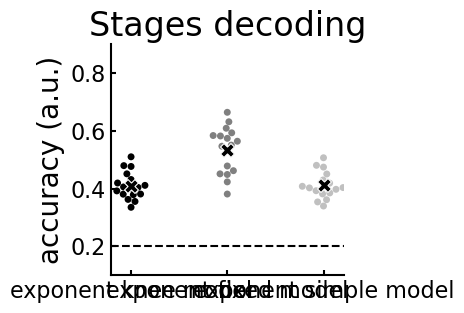

In [11]:
array_list = [ accuracy_K, accuracy_F, accuracy_F30]

titles =  ['exponent knee model','exponent fixed model','exponent simple model']
colors = ['black', 'grey', 'silver']

ax = plt.figure(figsize=(3,3))  

ax = seaborn.swarmplot(data=array_list, palette = colors);
ax.set_xticklabels(titles)

seaborn.scatterplot(x=[0,1,2], y=np.mean(array_list,1), marker='X', color='black', s=100, zorder=4, legend=False);
ax.axhline(y=0.2, color='black', linestyle='--');

plt.title('Stages decoding', fontsize = 24)
plt.ylabel('accuracy (a.u.)',fontsize=20)

plt.ylim(0.1, 0.9)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)  # Customize tick properties
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)


plt.savefig("/home/b1044271/Columbia/Plots/NOV24/EEG_decoding.svg", dpi = 600)

## Stats
### permutation against chance

In [12]:

# Specify the number of permutations
num_permutations = 10000

tvalue=np.zeros(3)
pvalue=np.zeros(3)
cohend=np.zeros(3)
for i in np.arange(len(array_list)):
    X = array_list[i]
    # Perform the permutation test
    tvalue[i],pvalue[i],cohend[i] = perform_permutation_test(X, np.ones(17)*0.2, num_permutations)

pvalue_bonf = pvalue * len(array_list)

# Create a DataFrame to store the results
results_table = pd.DataFrame({
    "Metric": ["Accuracy Knee", "Accuracy K", "Accuracy F"],
    "T-Value": tvalue,
    "P-Value (Bonferroni)": pvalue_bonf,
    "Cohen's D": cohend
})

# Save the table to a CSV file
file_path = "permutation_test_results.csv"
results_table.to_csv('/home/b1044271/Columbia/Plots/NOV24/Decode_EEG_stats_chance.svg', index=False)

# show stats
pvalue_bonf, tvalue, cohend

(array([0., 0., 0.]),
 array([18.40200387, 17.27641567, 19.139258  ]),
 array([6.31183526, 5.92576169, 6.56471134]))

### to each other

In [15]:
data = pd.DataFrame(np.transpose(array_list))
friedman_result, W, posthoc_result, z_values, effect_sizes, corrected_p_values = friedman_dunns(data)

friedman_result, W, corrected_p_values, z_values, effect_sizes

(FriedmanchisquareResult(statistic=25.529411764705884, pvalue=2.859951525640375e-06),
 0.7508650519031143,
           0         1         2
 0  1.000000  0.000166  1.000000
 1  0.000166  1.000000  0.000257
 2  1.000000  0.000257  1.000000,
 array([[2.78291642e-16, 4.03200824e+00, 1.03828538e-01],
        [4.03200824e+00, 2.78291642e-16, 3.92817970e+00],
        [1.03828538e-01, 3.92817970e+00, 2.78291642e-16]]),
           0         1         2
 0       NaN -0.806228 -0.020761
 1  0.806228       NaN  0.785467
 2  0.020761 -0.785467       NaN)